In [1]:
import xarray as xr 
import wclass
import constants as cnst
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error as mae
from scipy import ndimage

In [2]:
dat = xr.open_dataarray(cnst.TESTDATA).squeeze()

In [3]:
dat

<xarray.DataArray 'SM' (latitude: 655, longitude: 1309)>
[857395 values with dtype=float32]
Coordinates:
    time                     object ...
    depth                    float32 ...
  * latitude                 (latitude) float32 3.5 3.541 3.581 ... 29.95 29.99
  * longitude                (longitude) float32 -18.0 -17.96 ... 34.93 34.97
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  object ...
Attributes:
    standard_name:    moisture_content_of_soil_layer
    units:            kg m-2
    um_stash_source:  m01s08i223
    um_runid:         ad251
    um_streamid:      ape
    um_version:       10.3
    grid_mapping:     latitude_longitude

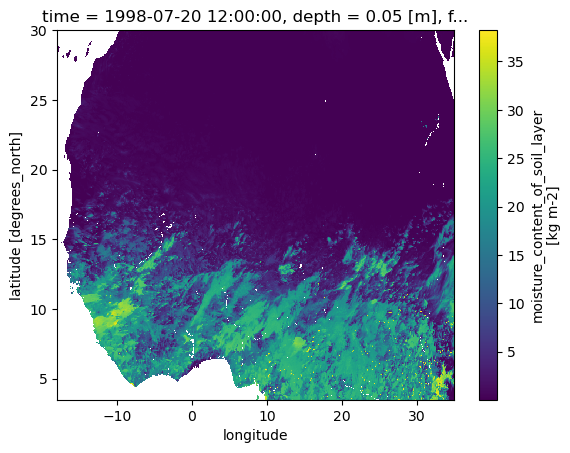

In [4]:
dat.plot()

In [5]:
### Create a wavelet decomposition object first. In this example, we initialise the SM5k 5km setup. The setups can be defined in land_wavelet.constants
wObj = wclass.landwav('SM5k')

Initialised wavelet with scales:  [5.00000000e+00 5.94603558e+00 7.07106781e+00 8.40896415e+00
 1.00000000e+01 1.18920712e+01 1.41421356e+01 1.68179283e+01
 2.00000000e+01 2.37841423e+01 2.82842712e+01 3.36358566e+01
 4.00000000e+01 4.75682846e+01 5.65685425e+01 6.72717132e+01
 8.00000000e+01 9.51365692e+01 1.13137085e+02 1.34543426e+02
 1.60000000e+02 1.90273138e+02 2.26274170e+02 2.69086853e+02
 3.20000000e+02 3.80546277e+02 4.52548340e+02 5.38173706e+02
 6.40000000e+02 7.61092554e+02 9.05096680e+02 1.07634741e+03
 1.28000000e+03 1.52218511e+03 1.81019336e+03 2.15269482e+03
 2.56000000e+03 3.04437021e+03 3.62038672e+03 4.30538965e+03
 5.12000000e+03]


In [6]:
### The wObj object saves certain infos on the initialised wavelet as well as the dataset the wavelet it supposed to be used on. IT IS IMPORTANT THAT THE INITIALISED WAVELET KNOWS ABOUT THE DATASET RESOLUTION

print('Initialised dataset resolution (info from utility function):', wObj.res)
print('Initialised wavelet scale start (info from utility function):',wObj.start)
print('Initialised scale numbers (info from utility function):',wObj.nb)
print('Initialised scales:', wObj.scales)

Initialised dataset resolution (info from utility function): 5
Initialised wavelet scale start (info from utility function): 5
Initialised scale numbers (info from utility function): 40
Initialised scales: [5.00000000e+00 5.94603558e+00 7.07106781e+00 8.40896415e+00
 1.00000000e+01 1.18920712e+01 1.41421356e+01 1.68179283e+01
 2.00000000e+01 2.37841423e+01 2.82842712e+01 3.36358566e+01
 4.00000000e+01 4.75682846e+01 5.65685425e+01 6.72717132e+01
 8.00000000e+01 9.51365692e+01 1.13137085e+02 1.34543426e+02
 1.60000000e+02 1.90273138e+02 2.26274170e+02 2.69086853e+02
 3.20000000e+02 3.80546277e+02 4.52548340e+02 5.38173706e+02
 6.40000000e+02 7.61092554e+02 9.05096680e+02 1.07634741e+03
 1.28000000e+03 1.52218511e+03 1.81019336e+03 2.15269482e+03
 2.56000000e+03 3.04437021e+03 3.62038672e+03 4.30538965e+03
 5.12000000e+03]


In [7]:
### The next step prepares the SM image for the wavelet routine. NaNs are removed by filling in zeros that can be masked again after wavelet application.
wObj.read_img(dat.values, dat.longitude.values, dat.latitude.values)

Mean res is 0.0405  I found that grid is not regular. If in doubt, please check.


Text(0.5, 1.0, 'SM anomaly without NaNs - note, there is ocean')

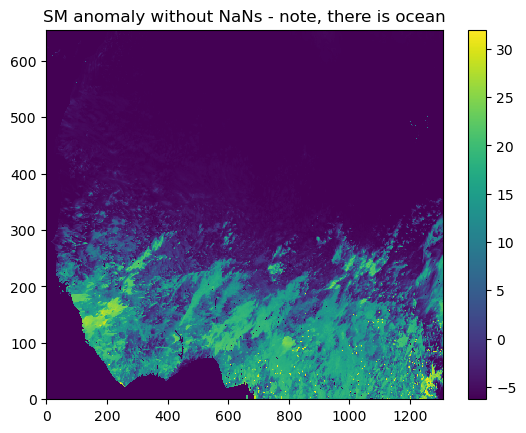

In [8]:
# The object saves the filtered image
plt.pcolormesh(wObj.image)  # the prepared (nans removed, anomaly) image
plt.colorbar()
plt.title('SM anomaly without NaNs - note, there is ocean')

In [9]:
# We now apply the wavelet scale decomposition to the image as defined in the wObj object. This step saves wavelet coefficients and powers to the object.
# The resulting powers could be used for diverse analyses.

coeffs, power, scales, period = wObj.applyWavelet(normed='none')

Wavelet coeffs (none or stddev) and power (none, stddev or scale) normed by: none Please note: Choose none if value reconstruction is intended.


In [10]:
wObj.power.shape   # 0 dimension corresponds to number of decomposed scales

(41, 655, 1309)

In [13]:
variableFull, scalesFull = wObj.applyInverseWavelet(per_scale=False)

In [14]:
# mask invalid areas again
original_anomaly = dat.values
variableFull[wObj.invalid] = np.nan

Text(0.5, 1.0, 'Reconstructed - original')

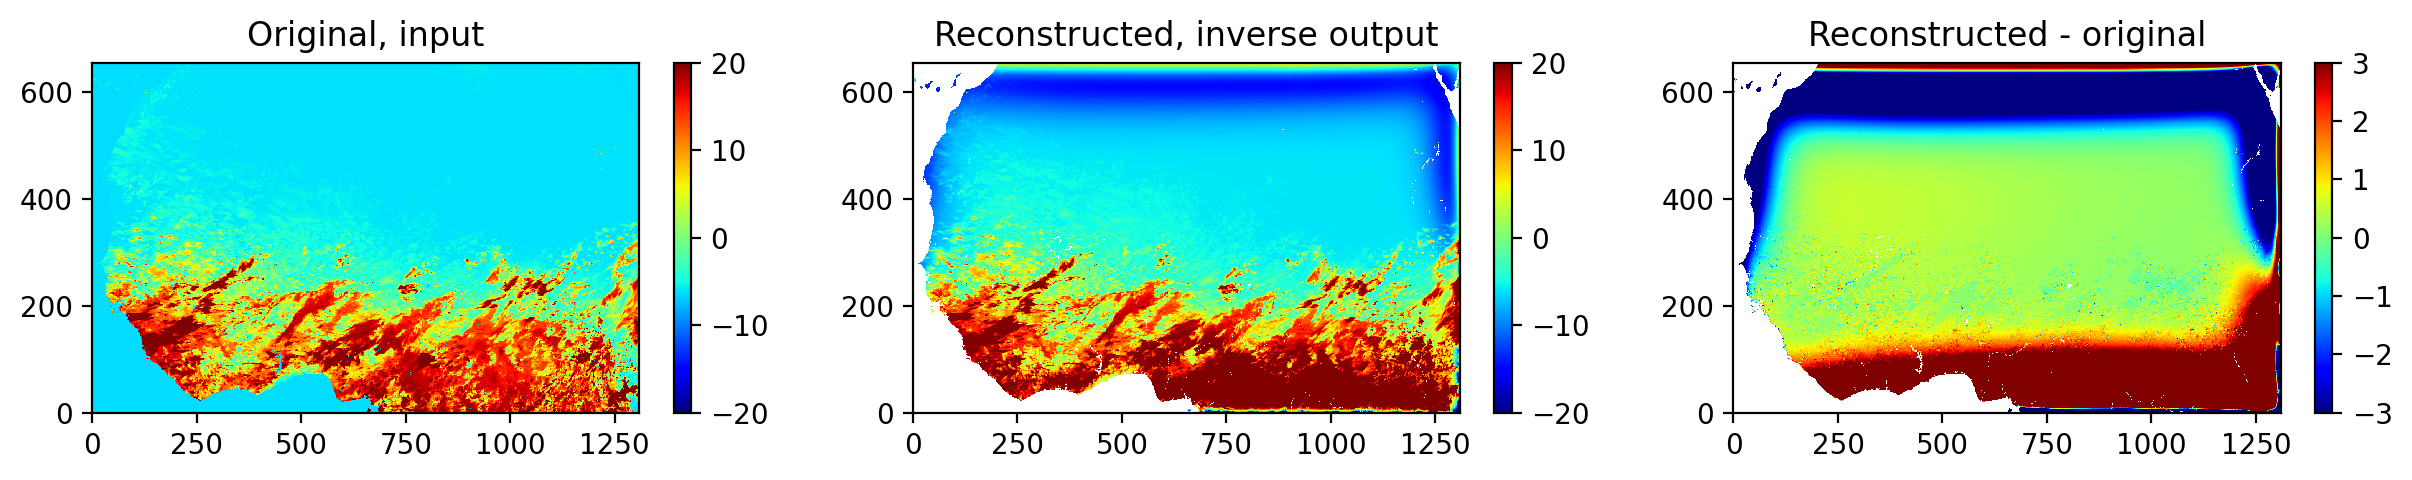

In [15]:
### Same powers as above but as contours plotted onto the SM image. NOTE THE EGDE EFFECTS FROM LARGE SCALES!

f = plt.figure(figsize=(15,5), dpi=200)

ax = f.add_subplot(231)

plt.pcolormesh(wObj.image, cmap='jet', vmin=-20, vmax=20)
plt.colorbar()
plt.title('Original, input')


ax = f.add_subplot(232)
plt.pcolormesh(variableFull, cmap='jet', vmin=-20, vmax=20)
plt.colorbar()
plt.title('Reconstructed, inverse output')

ax = f.add_subplot(233)
plt.pcolormesh(variableFull-wObj.image, cmap='jet', vmin=-3, vmax=3)
plt.colorbar()
plt.title('Diff: reconstructed - original')

In [16]:
## Get individual scales, set "per_scale=True" for same wavelet object

variableIndi, scalesIndi = wObj.applyInverseWavelet(per_scale=True)

In [17]:
variableIndi.shape

(41, 655, 1309)

In [18]:
scaleval = variableIndi.sum(axis=(1,2))

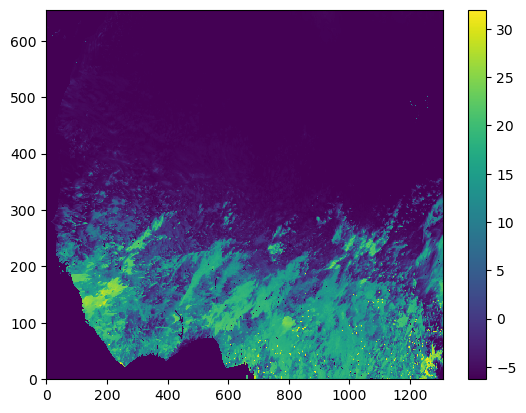

In [19]:
plt.pcolormesh(wObj.image)
plt.colorbar()

In [20]:
dat_filled = dat.values.copy()
dat_filled[np.isnan(dat.values)] = 0

Text(0.5, 1.0, 'Filtered minus original')

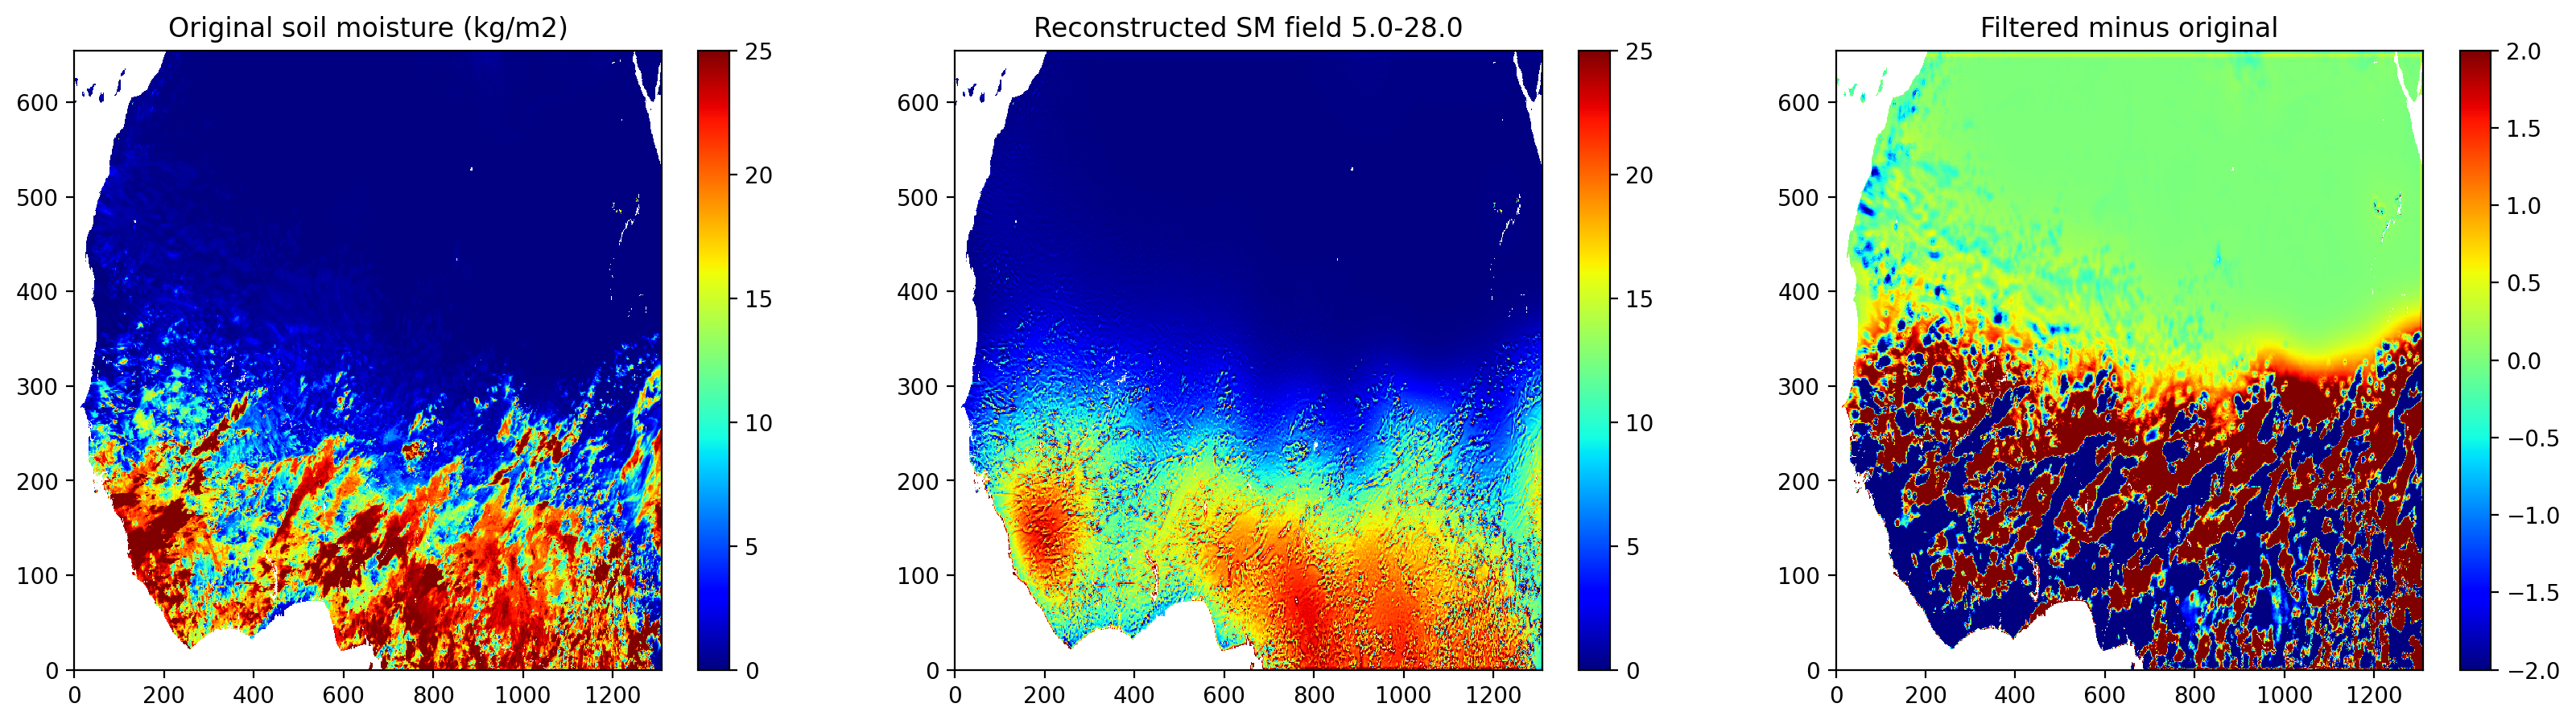

In [75]:
f = plt.figure(figsize=(20,5), dpi=200)


ax = f.add_subplot(131)

plt.pcolormesh(dat.values, cmap='jet', vmin=0, vmax=25)
plt.colorbar()
plt.title('Original soil moisture (kg/m2)')

mask = np.isnan(dat.values)

si = 0
plus = 10
ax = f.add_subplot(132)
#####################################
ar = variableIndi[si:si+plus,:,:].sum(axis=0) *1.5 + ndimage.gaussian_filter(dat_filled, 35, mode='nearest') #### THIS IS THE LINE FOR FILTERED CONSTRUCTION - GAUSSIAN SMOOTHING + SCALED SMALL SCALES

ar[mask] = np.nan
ar[ar<0] = 0
#####################################
plt.pcolormesh(ar, cmap='jet', vmin=0, vmax=25)
scales = str(np.floor(scalesIndi[si]))+'-'+str(np.floor(scalesIndi[si+plus])) 
plt.colorbar()
plt.title('Reconstructed SM field '+scales)

si = 21
plus = 5
ax = f.add_subplot(133)
plt.pcolormesh(ar-dat, cmap='jet', vmin=-2, vmax=2)
scales = str(np.floor(scalesIndi[si]))+'-'+str(np.floor(scalesIndi[si+plus]))+' km'
plt.colorbar()
plt.title('Filtered minus original')


In [76]:
print('original mean' , np.nanmean(dat[100:300,:]))   #### mean between pixels 100-300 north ~ Sahel area
print('original stddev' , np.nanstd(dat[100:300,:]))
print('original min' , np.nanmin(dat[100:300,:]))
print('original max' , np.nanmax(dat[100:300,:]))

original mean 11.7580595
original stddev 8.391533
original min 0.053222656
original max 38.23999


In [77]:
print('filtered mean' , np.nanmean(ar[100:300,:]))    ##### mean approximately the same
print('filtered stddev' , np.nanstd(ar[100:300,:]))
print('filtered min' , np.nanmin(ar[100:300,:]))
print('filtered max' , np.nanmax(ar[100:300,:]))

filtered mean 11.374563640765452
filtered stddev 6.033863207575709
filtered min 0.0
filtered max 50.439152163602046


Text(0.5, 1.0, 'Large-scale SM gradient (Zonal mean)')

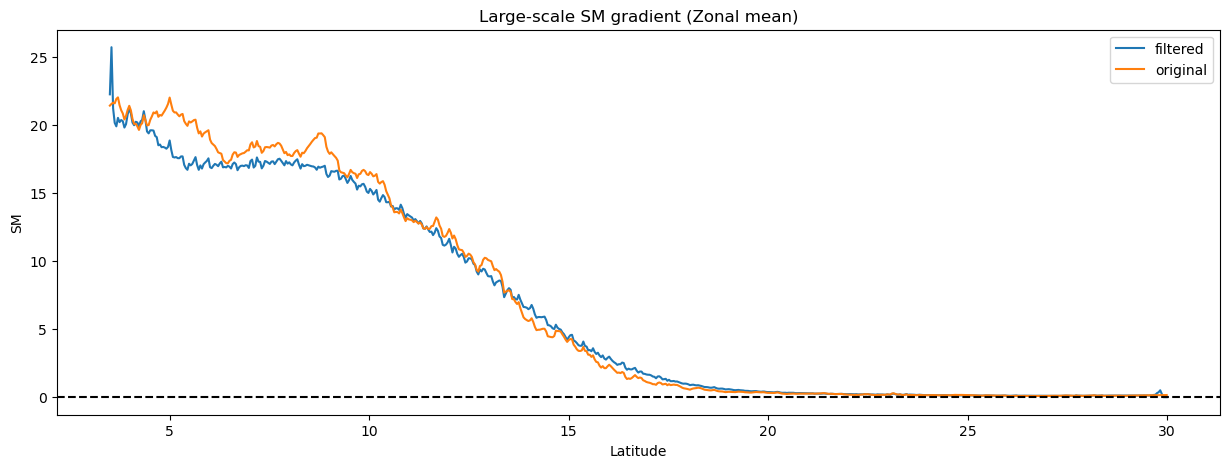

In [78]:
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(111)
ar_mean = np.nanmean(ar, axis=1)
dat_mean = np.nanmean(dat, axis=1)

plt.plot(dat.latitude, ar_mean, label='filtered')
plt.plot(dat.latitude, dat_mean, label='original')
plt.legend()
plt.axhline(0, color='k', linestyle='dashed')
ax.set_xlabel('Latitude')
ax.set_ylabel('SM')
plt.title('Large-scale SM gradient (Zonal mean)')

Text(0.5, 1.0, 'Zonal SM variability')

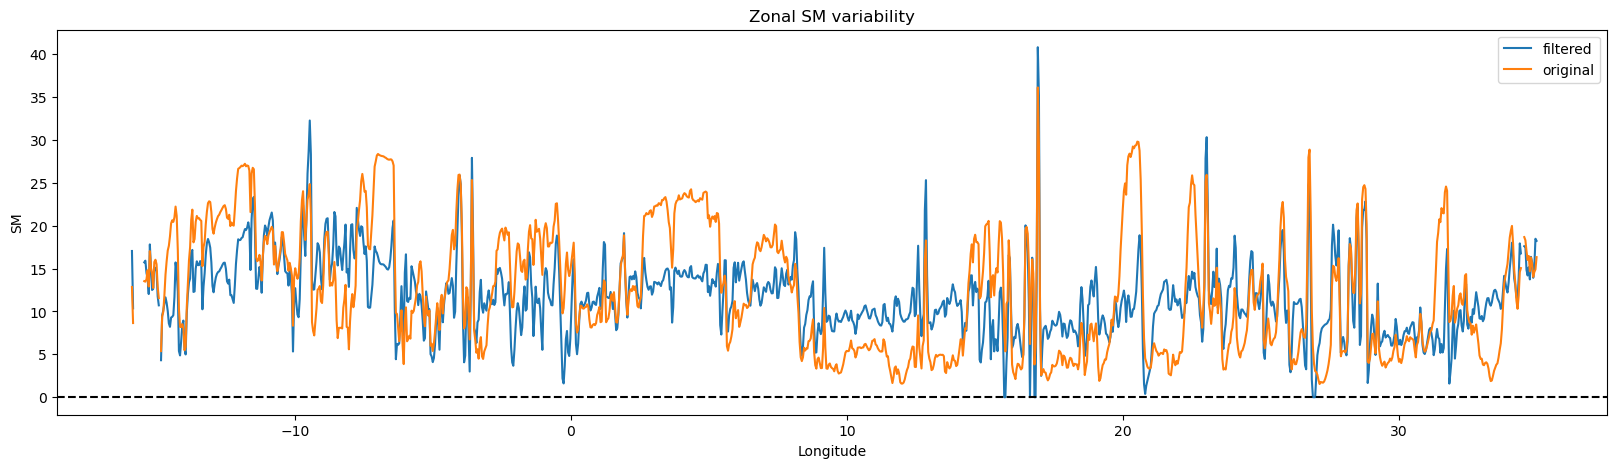

In [86]:
yy = 205

f = plt.figure(figsize=(20,5))
ax = f.add_subplot(111)
plt.plot(dat.longitude, ar[yy,::], label='filtered')
plt.plot(dat.longitude, dat[yy,::], label='original')
plt.legend()
plt.axhline(0, color='k', linestyle='dashed')
ax.set_xlabel('Longitude')
ax.set_ylabel('SM')
plt.title('Zonal SM variability')

In [80]:
#### FULL ROUND TRIP SANITY CHECK

wObj_after = wclass.landwav('SM5k')
wObj_orig = wclass.landwav('SM5k')

Initialised wavelet with scales:  [5.00000000e+00 5.94603558e+00 7.07106781e+00 8.40896415e+00
 1.00000000e+01 1.18920712e+01 1.41421356e+01 1.68179283e+01
 2.00000000e+01 2.37841423e+01 2.82842712e+01 3.36358566e+01
 4.00000000e+01 4.75682846e+01 5.65685425e+01 6.72717132e+01
 8.00000000e+01 9.51365692e+01 1.13137085e+02 1.34543426e+02
 1.60000000e+02 1.90273138e+02 2.26274170e+02 2.69086853e+02
 3.20000000e+02 3.80546277e+02 4.52548340e+02 5.38173706e+02
 6.40000000e+02 7.61092554e+02 9.05096680e+02 1.07634741e+03
 1.28000000e+03 1.52218511e+03 1.81019336e+03 2.15269482e+03
 2.56000000e+03 3.04437021e+03 3.62038672e+03 4.30538965e+03
 5.12000000e+03]
Initialised wavelet with scales:  [5.00000000e+00 5.94603558e+00 7.07106781e+00 8.40896415e+00
 1.00000000e+01 1.18920712e+01 1.41421356e+01 1.68179283e+01
 2.00000000e+01 2.37841423e+01 2.82842712e+01 3.36358566e+01
 4.00000000e+01 4.75682846e+01 5.65685425e+01 6.72717132e+01
 8.00000000e+01 9.51365692e+01 1.13137085e+02 1.34543426e+02


In [81]:
wObj_after.read_img(ar, dat.longitude.values, dat.latitude.values)  ## filtered image
wObj_orig.read_img(dat.values, dat.longitude.values, dat.latitude.values) ## original data

Mean res is 0.0405  I found that grid is not regular. If in doubt, please check.
Mean res is 0.0405  I found that grid is not regular. If in doubt, please check.


In [82]:
coeffs2, power2, scales2, period2 = wObj_after.applyWavelet(normed='scale') ########### normed power according to scale, no positive / negative filtering [ corrected keywords for applyWavelet!!]
coeffs, power, scales, period = wObj_orig.applyWavelet(normed='scale')

Wavelet coeffs (none or stddev) and power (none, stddev or scale) normed by: scale Please note: Choose none if value reconstruction is intended.
Wavelet coeffs (none or stddev) and power (none, stddev or scale) normed by: scale Please note: Choose none if value reconstruction is intended.


Text(0.5, 1.0, 'Relative contribution difference: (filtered-original)/original')

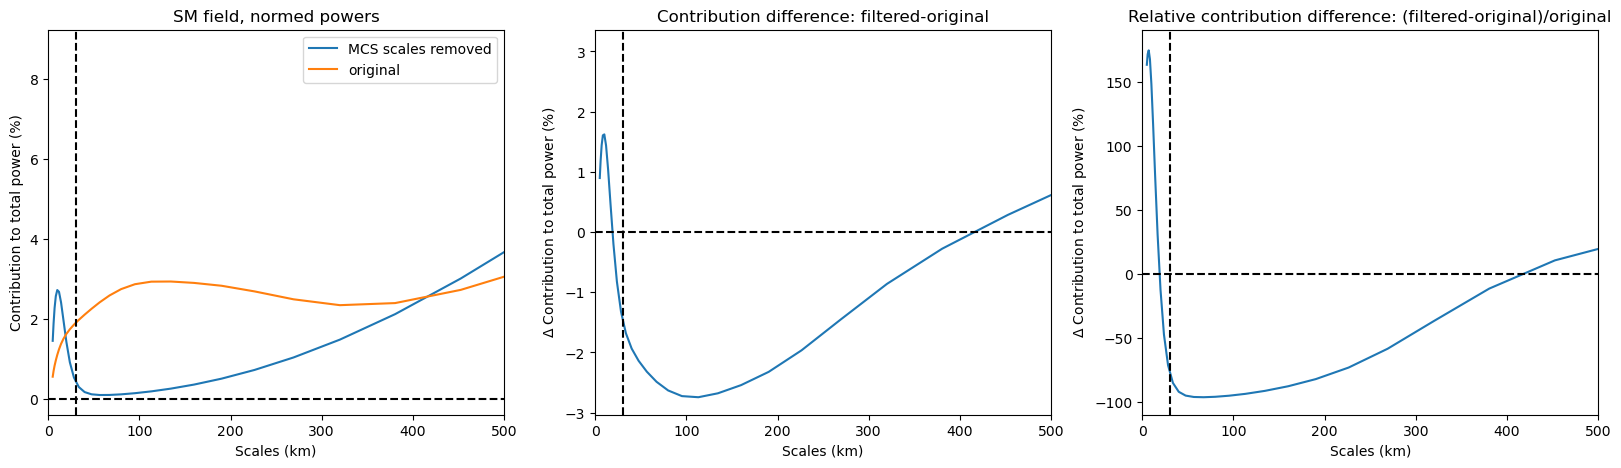

In [85]:
orig_perc = np.sum(power[:,150:300,:], axis=(1,2))/np.sum(power[:,150:300,:])
new_perc = np.sum(power2[:,150:300,:], axis=(1,2))/np.sum(power2[:,150:300,:])

f = plt.figure(figsize=(20,5))

ax = f.add_subplot(131)
plt.plot(wObj.scales,  new_perc*100, label='MCS scales removed')
plt.plot(wObj.scales,  orig_perc*100, label='original')
ax.set_xlim(0,1000)
plt.title('SM field, normed powers')
plt.legend()
plt.xlabel('Scales (km)')
plt.ylabel('Contribution to total power (%)')
plt.axhline(0, color='k', linestyle='dashed')
plt.axvline(30, color='k', linestyle='dashed')
ax.set_xlim(0,500)

ax = f.add_subplot(132)
plt.plot(wObj.scales,  (new_perc-orig_perc)*100)#/new_perc)
ax.set_xlim(0,500)
plt.title('')
plt.axhline(0, color='k', linestyle='dashed')
plt.axvline(30, color='k', linestyle='dashed')
plt.xlabel('Scales (km)')
plt.ylabel(r'$\Delta$ Contribution to total power (%)')
plt.title('Contribution difference: filtered-original')


ax = f.add_subplot(133)
plt.plot(wObj.scales,  (new_perc-orig_perc)/orig_perc*100)#/new_perc)
ax.set_xlim(0,500)
plt.title('')
plt.axhline(0, color='k', linestyle='dashed')
plt.axvline(30, color='k', linestyle='dashed')
plt.xlabel('Scales (km)')
plt.ylabel(r'$\Delta$ Contribution to total power (%)')
plt.title('Relative contribution difference: (filtered-original)/original')